In [1]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories
import pyemma
feat = pyemma.coordinates.featurizer(trajs[0].top)
feat.add_backbone_torsions()
feat.describe()

['PHI 0 ALA 2', 'PSI 0 ALA 2']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X = [feat.transform(traj) for traj in trajs]

# which of these states should we choose as milestones?
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X, k=1000, max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

19-09-16 17:20:23 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 897 steps.


In [4]:
msm = pyemma.msm.estimate_markov_model(dtrajs, lag=10)
msm.active_count_fraction

1.0

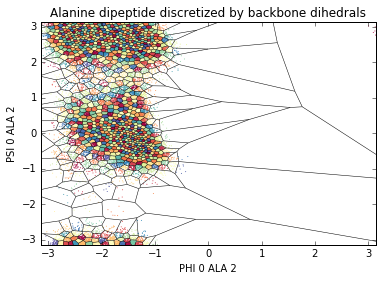

In [12]:
# voronoi plot
X_ = np.vstack(X)
inds = np.hstack(dtrajs)
c = inds # color by cluster ID
# c = np.array([msm.stationary_distribution[i] for i in inds]) # color by stationary distribution
# c = np.log([msm.stationary_distribution[i] for i in inds]) # color by free energy

def create_plot(centers, points, colors, cmap='Blues'):
    from scipy.spatial import Voronoi, voronoi_plot_2d
    voronoi = Voronoi(centers)
    plot = voronoi_plot_2d(voronoi, show_points=False, show_vertices=False, line_width=0.5)    
    plt.scatter(points[:,0], points[:,1], linewidths=0, c=colors, s=1, cmap=cmap)

    # axes and labels
    plt.xlabel(feat.describe()[0])
    plt.ylabel(feat.describe()[1])
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-np.pi, np.pi)
    plt.title('Alanine dipeptide discretized by backbone dihedrals')

create_plot(kmeans.clustercenters, X_, c, cmap='Spectral')
plt.savefig('ala_voronoi_stained_glass.png',dpi=300)

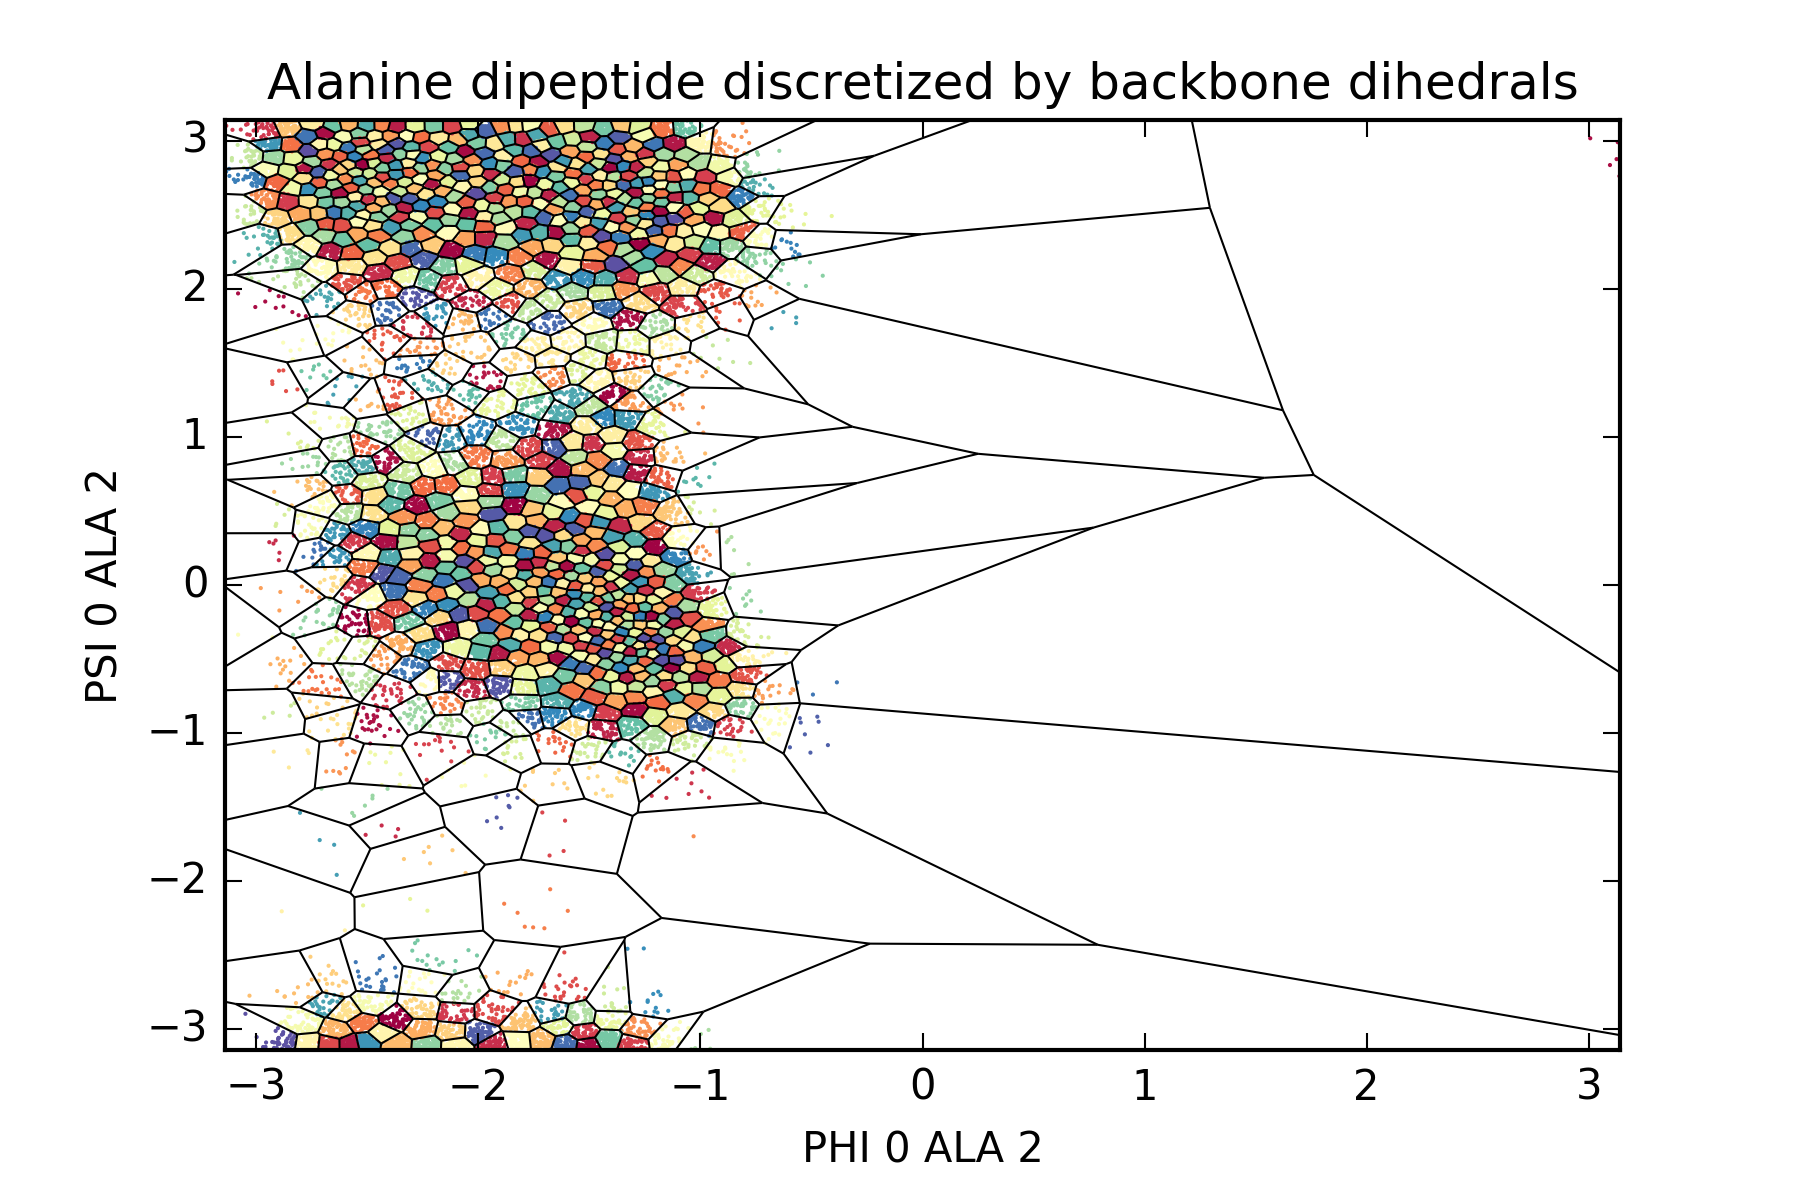

In [13]:
from IPython.display import Image
Image('ala_voronoi_stained_glass.png', retina=True)

In [22]:
from tqdm import tqdm
def estimate_gamma_version_1(dtrajs):
    '''
    iniitial implementation of estimator for Gamma
    '''
    
    dtraj_stack = np.hstack(dtrajs)
    n_states = len(set(dtraj_stack))
    
    gamma = np.zeros((n_states,n_states))
    
    for dtraj in tqdm(dtrajs):
        for i in range(n_states):
            indices = list(np.arange(len(dtraj))[dtraj==i]) + [len(dtraj)]
            for t in range(len(indices)-1):
                js = set(dtraj[indices[t]:indices[t+1]])
                for j in (js - set([i])):
                    gamma[i,j] += 1
        
    for i in range(n_states):
        gamma[i] /= np.sum(dtraj_stack==i)
    
    return gamma

In [23]:
gamma = estimate_gamma_version_1(dtrajs)

100%|██████████| 10/10 [00:29<00:00,  2.85s/it]


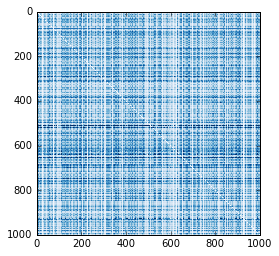

In [24]:
plt.imshow(gamma, interpolation='none', cmap='Blues')

In [30]:
def metastability_index(gamma, M):
    '''
    possibly buggy, since this is giving infs a lot of the time
    
    numerator = max_{i \in M} (max_{j \in M \minus i} Gamma[i,j])
    denominator = min_{i \not\in M} (max_{j \in M} Gamma[i,j])
    '''
    not_M = set(range(len(gamma))) - set(M)
    M_minus = lambda i:set(M) - set([i])
    
    numerator = max([max([gamma[i,j] for j in M_minus(i) if (i != j)]) for i in M])
    denominator = min([max([gamma[i,j] for j in M if (i != j)]) for i in not_M])
    return numerator / denominator

metastability_index(gamma, range(10))

1.9344262295081966

In [31]:
def remove_worst_using_numerator(gamma, M):
    '''
    identifies i the worst trial microstate currently in M, and removes it
    
    M <-- M \ i
    
    where i is the element of M for which the probability
    is the highest that, after hitting i, the trajectory
    will hit some other target milestone j \in M before hitting i
    again
    '''
    M = list(M)
    i = np.argmax([max(gamma[i, np.array(list(set(M) - set([i])))]) for i in M])
    _ = M.pop(i)
    return set(M)

def greedy_subtraction_optimizer(gamma, target_size = 3, callback=None):
    '''
    at each iteration, remove the "worst" milestone identified in the numerator of the metastability index
    '''
    M = set(range(len(gamma)))
    for _ in tqdm(range(len(M) - target_size)):
        M = remove_worst_using_numerator(gamma, M)
        if callback: callback(M)
    return M

Ms = []
metastability_indices = []

def callback(M):
    Ms.append(M)
    metastability_indices.append(metastability_index(gamma, M))

M = greedy_subtraction_optimizer(gamma, callback=callback)

100%|██████████| 997/997 [04:31<00:00,  3.67it/s]


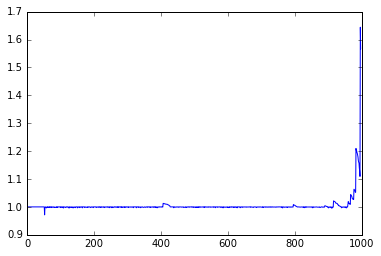

In [32]:
plt.plot(metastability_indices)

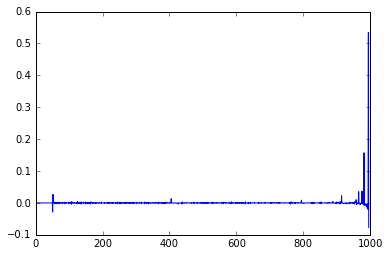

In [33]:
plt.plot(np.diff(metastability_indices))

In [45]:
# what about greedy addition?

def add_best_using_denominator_term(gamma, M):
    '''
    identifies i the best trial microstate not currently in M, the denominator of metastability_index
    
    M <-- M + {i}
    '''
    l = list(set(range(len(gamma))) - set(M))
    i = np.argmin([max(gamma[i]) for i in l])
    
    return set(M).union(set([i]))

def greedy_addition_optimizer(gamma, init_M, target_size = 150, callback=None):
    '''
    at each iteration, add the "best" trial milestone identified in the denominator of the metastability index
    '''
    M = init_M
    #for _ in tqdm(range(target_size - len(init_M))):
    for _ in range(target_size - len(init_M)):
        M = add_best_using_denominator_term(gamma, M)
        if callback: callback(M)
    return M

Ms = []
metastability_indices = []
init_M = np.random.randint(0,1000,1)

M = greedy_addition_optimizer(gamma, init_M, target_size=20, callback=callback)

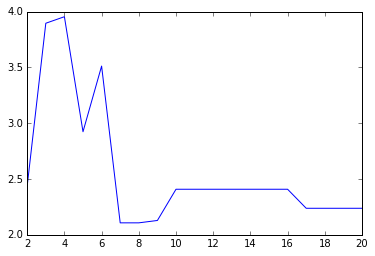

In [46]:
plt.plot([len(M) for M in Ms], metastability_indices)

In [49]:
results = dict()

best_M_index_so_far = np.inf

for i in tqdm(range(len(gamma))):
    try:
        Ms = []
        metastability_indices = []
        M = greedy_addition_optimizer(gamma, [i], target_size=10, callback=callback)
    
        results[i] = (Ms, metastability_indices)
    
        min_M = min(metastability_indices)
        if min_M < best_M_index_so_far:
            print(min_M)
            best_M_index_so_far = min_M
    except:
        pass

  0%|          | 1/1000 [00:00<11:28,  1.45it/s]

1.80268085945


  0%|          | 2/1000 [00:01<11:06,  1.50it/s]

1.65730337079


  4%|▍         | 39/1000 [00:24<09:53,  1.62it/s]

1.62822787305


  7%|▋         | 67/1000 [00:41<09:29,  1.64it/s]

1.59735759151


  7%|▋         | 73/1000 [00:45<09:39,  1.60it/s]

1.57007687759


 10%|█         | 101/1000 [01:02<09:09,  1.64it/s]

1.55263157895


 13%|█▎        | 134/1000 [01:22<08:53,  1.62it/s]

1.45377488665


 72%|███████▏  | 723/1000 [30:17<31:45:25, 412.73s/it]

0.901785714286


 73%|███████▎  | 727/1000 [30:19<10:45:41, 141.91s/it]

0.883495145631


 75%|███████▍  | 746/1000 [30:31<03:23,  1.25it/s]

0.776836887489


 79%|███████▉  | 790/1000 [31:00<02:11,  1.59it/s]

0.756548818465


 79%|███████▉  | 794/1000 [31:02<02:09,  1.59it/s]

0.658275916066


 80%|███████▉  | 795/1000 [31:03<02:07,  1.61it/s]

0.611650485437


 82%|████████▏ | 820/1000 [31:19<01:54,  1.57it/s]

0.600323624595


 98%|█████████▊| 977/1000 [32:57<00:14,  1.57it/s]

0.553612853338


100%|██████████| 1000/1000 [33:11<00:00,  1.58it/s]


In [50]:
# let's associate each state with the minimum metastability index found by greedy expansion around it

min_meta = np.zeros(len(gamma))
for i in results.keys():
    min_meta[i] = np.min(results[i][1])

In [67]:
bad_inds = np.arange(len(min_meta))[min_meta==0]
bad_inds

array([725])

In [53]:
# so the only one that wasn't set is index 725
results[725]

KeyError: 725

In [68]:
best = np.argsort(min_meta)[len(bad_inds)]

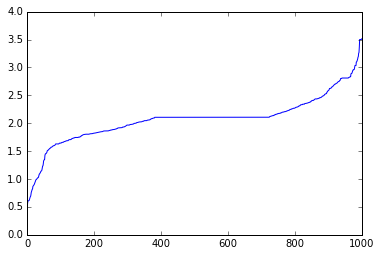

In [181]:
plt.plot(np.trapz(sorted(min_meta))

In [186]:
# impute missing data using sample mean
min_meta[bad_inds] = np.mean(min_meta)

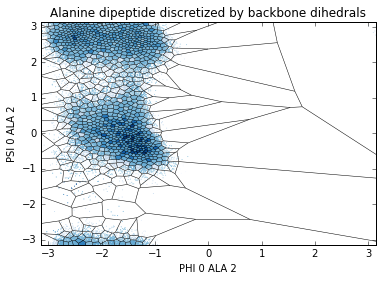

In [187]:
create_plot(kmeans.clustercenters, X_, [min_meta[inds[i]] for i in range(len(X_))], cmap='Blues_r')
plt.savefig('ala_voronoi_min_meta.png',dpi=300)

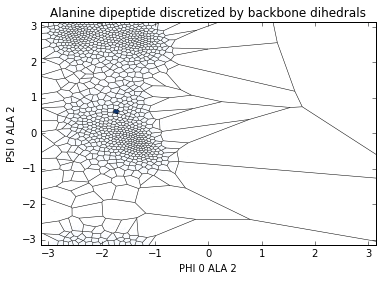

In [190]:
create_plot(kmeans.clustercenters, X_, [1.0*(inds[i] in bad_inds) for i in range(len(X_))], cmap='Blues')
plt.savefig('ala_voronoi_bad_inds.png',dpi=300)

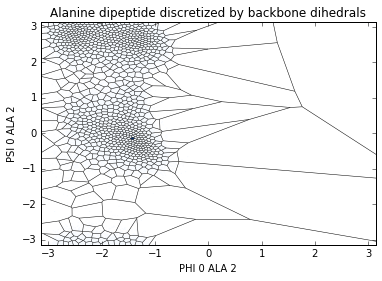

In [191]:
create_plot(kmeans.clustercenters, X_, [1.0*(inds[i]==best) for i in range(len(X_))], cmap='Blues')
plt.savefig('ala_voronoi_best.png',dpi=300)

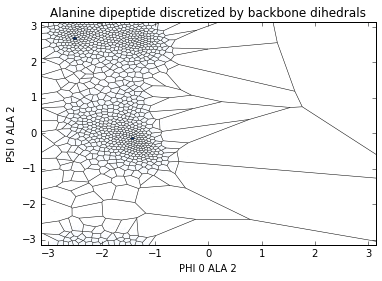

In [83]:
best_ind = np.argmin(results[best][1])
best_set = results[best][0][best_ind]
create_plot(kmeans.clustercenters, X_, [1.0*(inds[i] in best_set) for i in range(len(X_))], cmap='Blues')
plt.savefig('ala_voronoi_best_set.png',dpi=300)

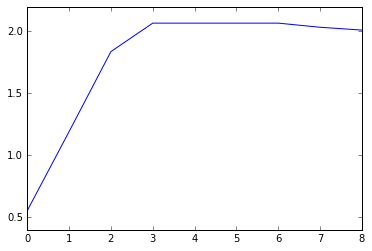

In [84]:
plt.plot(results[best][1])

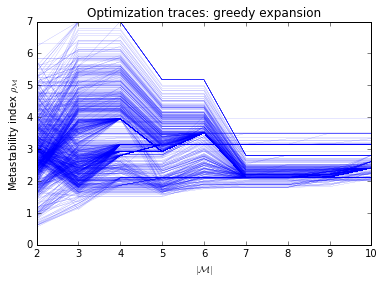

In [192]:
for i in results.keys():
    plt.plot([len(r) for r in results[0][0]], results[i][1],color='blue',linewidth=0.1)
plt.ylabel(r'Metastability index $\rho_\mathcal{M}$')
plt.xlabel(r'$| \mathcal{M} |$')
plt.title('Optimization traces: greedy expansion')

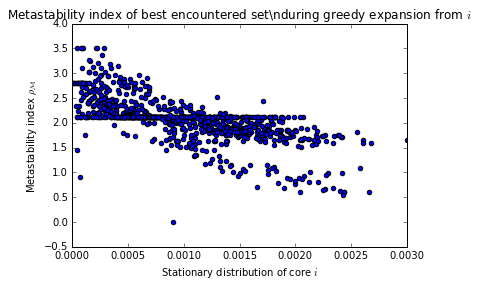

In [96]:
# how does this correlate with the stationary weight of the starting state
plt.scatter(msm.stationary_distribution, min_meta)
plt.ylabel(r'Metastability index $\rho_\mathcal{M}$')
plt.xlim(0,max(msm.stationary_distribution))
plt.xlabel(r'Stationary distribution of core $i$')
plt.title(r'Metastability index of best encountered set\nduring greedy expansion from $i$')

In [163]:
# let me apply evolutionary algorithms to optimizing this function

# using the example from DEAP:

import array
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(gamma))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalMetastabilityFitness(individual):
    try:
        M = np.arange(len(gamma))[np.array(individual)==1]
        index = metastability_index(gamma, M)
        return (- index,)
    except:
        return (- 100000,)

toolbox.register("evaluate", evalMetastabilityFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [122]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                               stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std      	min     	max     
0  	300   	-2.08862	0.0588099	-2.32283	-1.96262
1  	180   	-2.04731	0.0398154	-2.28682	-1.96262
2  	180   	-2.02461	0.0338478	-2.20149	-1.96262
3  	204   	-2.00547	0.0199071	-2.10345	-1.95789
4  	181   	-1.9979 	0.0247676	-2.12371	-1.95789
5  	197   	-1.98937	0.0244569	-2.10204	-1.95789
6  	203   	-1.98473	0.0297135	-2.20149	-1.95789
7  	177   	-1.97412	0.0218689	-2.10714	-1.95575
8  	186   	-1.97163	0.0304223	-2.20149	-1.93878
9  	183   	-1.96566	0.0265525	-2.28682	-1.93878
10 	186   	-1.96187	0.0179112	-2.10204	-1.92742
11 	182   	-1.96097	0.0186345	-2.08081	-1.92742
12 	161   	-1.96151	0.0259104	-2.1223 	-1.91045
13 	196   	-1.95321	0.023659 	-2.08081	-1.9058 
14 	191   	-1.94702	0.0299341	-2.20149	-1.9058 
15 	168   	-1.93857	0.0295321	-2.20149	-1.9058 
16 	160   	-1.93185	0.0379657	-2.28682	-1.9058 
17 	174   	-1.92425	0.0325528	-2.20149	-1.9058 
18 	169   	-1.92082	0.0394985	-2.20149	-1.90291
19 	192   	-1.91955	0.0418226	-2.20149	-

In [124]:
np.sum(min_meta < 1.87629)

250

In [129]:
sum([l['nevals'] for l in log])

7518

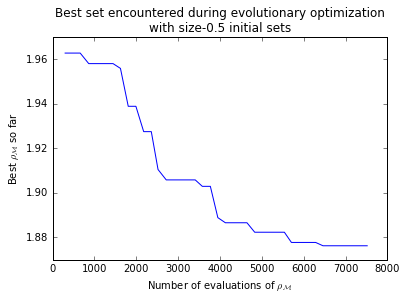

In [142]:
# what does the training curve look like?
plt.plot(np.cumsum([l['nevals'] for l in log]), [-1 * l['max'] for l in log])
plt.xlabel(r'Number of evaluations of $\rho_\mathcal{M}$')
plt.ylabel(r'Best $\rho_\mathcal{M}$ so far')
plt.title('Best set encountered during evolutionary optimization\nwith size-0.5 initial sets')

In [136]:
# what's the best milestone set found by evolutionary optimization?
meta_inds = [evalMetastabilityFitness(ind) for ind in pop]
best_evo_set = pop[np.argmax(meta_inds)]

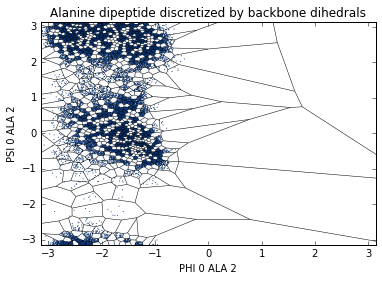

In [138]:
create_plot(kmeans.clustercenters, X_, [1.0*(best_evo_set[inds[i]]) for i in range(len(X_))], cmap='Blues')
plt.savefig('ala_voronoi_best_evo_set.png',dpi=300)

In [202]:
# let's redo this, but with much sparser individuals in the initial population?

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(gamma))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

np.random.seed(0)
pop_sparse = toolbox.population(n=300)
for ind in pop_sparse:
    for i in range(len(ind)):
        if np.random.rand() < 0.95:
            ind[i] *= 0
#print('Does each individual have at least one milestone in M?', np.alltrue(pop_sparse.sum(1)>0))
#pop_sparse = [array('b', ind) for ind in pop_sparse]

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop_sparse, log_sparse = algorithms.eaSimple(pop_sparse, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                               stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std     	min     	max     
0  	300   	-2.53539	0.339605	-4.33824	-1.79756
1  	188   	-2.32336	0.210611	-4      	-1.79756
2  	176   	-2.23279	0.161572	-3.26667	-1.79756
3  	191   	-2.16581	0.168038	-3      	-1.66817
4  	192   	-2.1341 	0.216535	-4.37922	-1.66817
5  	188   	-2.10182	0.199573	-3      	-1.63333
6  	161   	-2.03847	0.169055	-3      	-1.65963
7  	181   	-2.01884	0.198007	-2.77083	-1.64661
8  	184   	-1.97341	0.210788	-3.15171	-1.59689
9  	183   	-1.93485	0.228217	-2.79886	-1.59689
10 	184   	-1.89572	0.241717	-2.68182	-1.59689
11 	196   	-1.84883	0.235158	-2.52137	-1.56967
12 	182   	-1.80565	0.242262	-2.73148	-1.51626
13 	177   	-1.78636	0.243943	-2.52137	-1.51626
14 	156   	-1.73823	0.2291  	-2.52137	-1.48366
15 	190   	-1.74319	0.242302	-2.52137	-1.48366
16 	166   	-1.71461	0.249803	-2.52137	-1.45552
17 	188   	-1.69266	0.245146	-2.52137	-1.45552
18 	194   	-1.71392	0.271683	-2.52137	-1.45552
19 	192   	-1.67201	0.266244	-2.52137	-1.45552
20 	178   	-1

In [219]:
# let's redo this, but with even sparser individuals in the initial population?

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(gamma))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

np.random.seed(0)
pop_really_sparse = toolbox.population(n=300)
for ind in pop_really_sparse:
    for i in range(len(ind)):
        if np.random.rand() < 0.99:
            ind[i] *= 0

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop_really_sparse, log_really_sparse = algorithms.eaSimple(pop_really_sparse, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                               stats=stats, halloffame=hof, verbose=True)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars


gen	nevals	avg 	std	min 	max     
0  	300   	-inf	nan	-inf	-1.07477
1  	181   	-335.91	5763.72	-100000	-0.75951
2  	174   	-2.2151	0.401687	-4.57143	-0.75951
3  	176   	-1002.08	9949.67 	-100000 	-0.75951
4  	177   	-668.634	8137.54 	-100000 	-0.75951
5  	184   	-1668.56	12801.7 	-100000 	-0.659138
6  	191   	-4001.74	19595.6 	-100000 	-0.659138
7  	189   	-6668.25	24944   	-100000 	-0.659138
8  	175   	-4001.46	19595.6 	-100000 	-0.659138
9  	186   	-5668.05	23120.1 	-100000 	-0.659138
10 	166   	-3334.64	17950.3 	-100000 	-0.659138
11 	173   	-6001.21	23748.4 	-100000 	-0.659138
12 	190   	-5334.52	22469.5 	-100000 	-0.659138
13 	183   	-5334.44	22469.5 	-100000 	-0.617801
14 	170   	-4001.05	19595.7 	-100000 	-0.617801
15 	177   	-2667.69	16110.6 	-100000 	-0.617801
16 	183   	-1000.98	9949.78 	-100000 	-0.617801
17 	175   	-334.383	5763.81 	-100000 	-0.617801
18 	178   	-2334.33	15095.8 	-100000 	-0.617801
19 	192   	-3667.64	18794   	-100000 	-0.617801
20 	172   	-1334.37	11469.6 

In [226]:
# each of the starting conditions for the greedy expansion optimizer were selected at random
# in other words, we could have done it in many different orders
many_running_minima = []
inds=np.arange(len(min_meta))
for i in range(100):
    np.random.shuffle(inds)
    many_running_minima.append(running_minimum(min_meta[inds]))

In [236]:
mean = np.mean(many_running_minima,0)
stdev = np.std(many_running_minima,0)

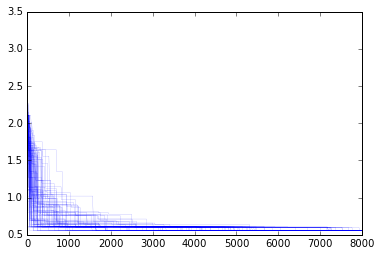

In [237]:
for rm in many_running_minima:
    plt.plot((1+np.arange(len(min_meta)))*8, rm, linewidth=0.1,color='blue',label='Greedy expansion (random order)')

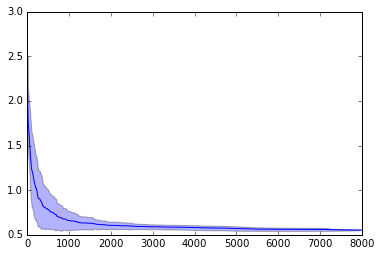

In [241]:
plt.plot((1+np.arange(len(min_meta)))*8, mean, linewidth=1,color='blue',label='Greedy expansion (random order)')
plt.fill_between((1+np.arange(len(min_meta)))*8, mean - stdev, mean + stdev, alpha=0.3)

(0, 2)

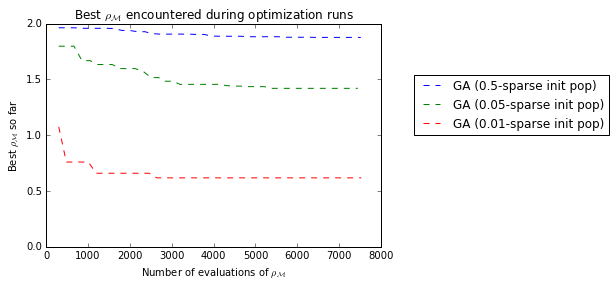

In [248]:
# what do all the training curves look like?

best_per_generation = [-1 * l['max'] for l in log]
best_per_generation_sparse = [-1 * l['max'] for l in log_sparse]
best_per_generation_really_sparse = [-1 * l['max'] for l in log_really_sparse]

def running_minimum(array):
    return [min(array[:i]) for i in range(1, len(array)+1)]

# evolutionary algorithm baselines
plt.plot(np.cumsum([l['nevals'] for l in log]), running_minimum(best_per_generation),linestyle='--', label='GA (0.5-sparse init pop)')
plt.plot(np.cumsum([l['nevals'] for l in log_sparse]), running_minimum(best_per_generation_sparse),linestyle='--', label='GA (0.05-sparse init pop)')
plt.plot(np.cumsum([l['nevals'] for l in log_really_sparse]), running_minimum(best_per_generation_really_sparse),linestyle='--', label='GA (0.01-sparse init pop)')

## greedy expansion performance
#plt.plot((1+np.arange(len(min_meta)))*8, mean, linewidth=1,color='blue',label='Greedy expansion (random order)')
#plt.fill_between((1+np.arange(len(min_meta)))*8, mean - stdev, mean + stdev, alpha=0.2)
#plt.plot((1+np.arange(len(min_meta)))*8, running_minimum(min_meta[np.argsort(-msm.stationary_distribution)]),label=r'Greedy expansion ($\pi$-ordered)')

plt.xlabel(r'Number of evaluations of $\rho_\mathcal{M}$')
plt.ylabel(r'Best $\rho_\mathcal{M}$ so far')
plt.title(r'Best $\rho_\mathcal{M}$ encountered during optimization runs')
plt.legend(loc=(1.1,0.5))
plt.ylim(0,2)

(0, 2)

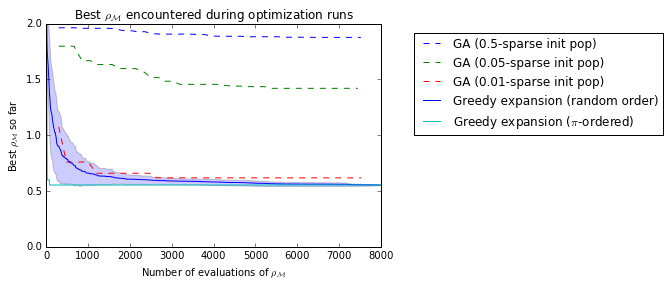

In [247]:
# what do all the training curves look like?

best_per_generation = [-1 * l['max'] for l in log]
best_per_generation_sparse = [-1 * l['max'] for l in log_sparse]
best_per_generation_really_sparse = [-1 * l['max'] for l in log_really_sparse]

def running_minimum(array):
    return [min(array[:i]) for i in range(1, len(array)+1)]

# evolutionary algorithm baselines
plt.plot(np.cumsum([l['nevals'] for l in log]), running_minimum(best_per_generation),linestyle='--', label='GA (0.5-sparse init pop)')
plt.plot(np.cumsum([l['nevals'] for l in log_sparse]), running_minimum(best_per_generation_sparse),linestyle='--', label='GA (0.05-sparse init pop)')
plt.plot(np.cumsum([l['nevals'] for l in log_really_sparse]), running_minimum(best_per_generation_really_sparse),linestyle='--', label='GA (0.01-sparse init pop)')

# greedy expansion performance
plt.plot((1+np.arange(len(min_meta)))*8, mean, linewidth=1,color='blue',label='Greedy expansion (random order)')
plt.fill_between((1+np.arange(len(min_meta)))*8, mean - stdev, mean + stdev, alpha=0.2)
plt.plot((1+np.arange(len(min_meta)))*8, running_minimum(min_meta[np.argsort(-msm.stationary_distribution)]),label=r'Greedy expansion ($\pi$-ordered)')

plt.xlabel(r'Number of evaluations of $\rho_\mathcal{M}$')
plt.ylabel(r'Best $\rho_\mathcal{M}$ so far')
plt.title(r'Best $\rho_\mathcal{M}$ encountered during optimization runs')
plt.legend(loc=(1.1,0.5))
plt.ylim(0,2)

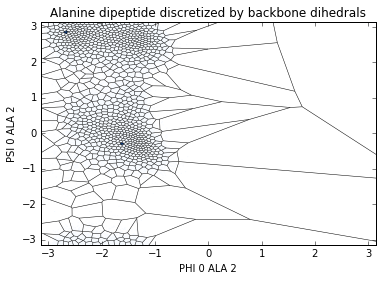

In [221]:
meta_inds = [evalMetastabilityFitness(ind) for ind in pop_really_sparse]
best_evo_set = pop_really_sparse[np.argmax(meta_inds)]
create_plot(kmeans.clustercenters, X_, [1.0*(best_evo_set[inds[i]]) for i in range(len(X_))], cmap='Blues')
plt.savefig('ala_voronoi_best_sparse_evo_set.png',dpi=300)

In [223]:
np.sum(best_evo_set)

2

In [224]:
np.where(best_evo_set)

(array([ 86, 680]),)

In [225]:
best_set

{726, 976}

In [249]:
# let's redo this, but with one-sparse individuals instead

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(gamma))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# initialize each individual to contain only a single microstate
np.random.seed(0)
pop_one_sparse = toolbox.population(n=300)
for i,ind in enumerate(pop_one_sparse):
    for j in range(len(ind)):
        if i != j:
            ind[j] *= 0

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop_one_sparse, log_one_sparse = algorithms.eaSimple(pop_one_sparse, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                               stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std	min    	max    
0  	300   	-100000	0  	-100000	-100000
1  	191   	-81000.5	39229.1	-100000	-0.957553
2  	169   	-33001.6	47020.1	-100000	-0.860335
3  	195   	-335.623	5763.74	-100000	-0.957553
4  	190   	-2.21737	0.222966	-2.99893	-0.957553
5  	194   	-2.15947	0.231466	-3.42677	-0.957553
6  	188   	-2.11529	0.293128	-5.09654	-0.957553
7  	178   	-2.06607	0.262849	-2.68182	-0.957553
8  	194   	-335.381	5763.75 	-100000 	-0.957553
9  	176   	-1.99646	0.320753	-2.92079	-0.957553
10 	186   	-668.6  	8137.55 	-100000 	-0.957553
11 	185   	-668.477	8137.56 	-100000 	-0.957553
12 	188   	-1335.06	11469.6 	-100000 	-0.957553
13 	193   	-668.299	8137.57 	-100000 	-0.957553
14 	193   	-1001.44	9949.73 	-100000 	-0.957553
15 	178   	-334.695	5763.79 	-100000 	-0.957553
16 	192   	-1.29192	0.610701	-3.31461	-0.957553
17 	191   	-1.26118	0.590749	-3.31461	-0.957553
18 	180   	-1.22986	0.565852	-2.92079	-0.957553
19 	165   	-1.24877	0.575377	-3.06024	-0.957553
20 	188   	-1.33

In [258]:
# let's try a different optimizer, incorporating the best of both worlds
import numpy as np
import numpy.random as npr

class MCSA():
   def __init__(self,
             proposal_function,
             objective_function,
             annealing_schedule):
      '''
      Monte Carlo Simulated Annealing
      
      Parameters
      ----------
      proposal_function : function
         accepts a solution object and returns a different solution object
      objective_function : function
         accepts a solution object and returns a real number
      annealing_schedule : array-like
         inverse temperature at each step of optimization
      '''
      self.proposal_function = proposal_function
      self.objective_function = objective_function
      self.annealing_schedule = annealing_schedule

   def maximize(self, init_solution):
      '''
      Maximize the objective function, given an initial solution
      Parameters
      ----------
      init_solution : object
         object that can be passed to proposal_function or objective_function
      Returns
      -------
      solutions : list of tuples
         each tuple contains:
            (solution object, objective function value)
      '''

      solutions = [(init_solution,self.objective_function(init_solution))]


      for beta in self.annealing_schedule:
         old_soln,old_f=solutions[-1]
         proposal = self.proposal_function(old_soln)
         f_proposal = self.objective_function(proposal)
         delta_Q = f_proposal - old_f
         if npr.rand() < np.exp(delta_Q * beta):
            solutions.append((proposal,f_proposal))
         else:
            solutions.append((old_soln,old_f))

      return solutions

In [266]:
def get_j_dagger(gamma, i):
    '''
    j_dagger(i) = argmax_{k=/=i} Gamma_ik

    eq. 8 : the index of the trial milestone that the trajectory is most likely to hit
    '''

    return np.argmax(gamma[i])

def update_M(gamma, M):
    '''
    M --> {j_dagger(i) | i \in M}
    '''
    return set([get_j_dagger(gamma, i) for i in M])

def robustify(proposal):
    def robustified(M):
        try:
            return proposal(M)
        except:
            return M
        
    return robustified

proposal_library_ = [lambda M:remove_worst_using_numerator(gamma, M),
                    lambda M:add_best_using_denominator_term(gamma, M),
                    lambda M:update_M(gamma, M)
                   ]

proposal_library = [robustify(proposal) for proposal in proposal_library]

def proposal_function(M):
    return np.random.choice(proposal_library)(M)

In [267]:
def objective_function(M):
    try:
        return - metastability_index(gamma, M)
    except:
        return - 10000

In [268]:
n_iter = 10
annealing_schedule = np.linspace(0,n_iter,n_iter)

In [ ]:
mcsa = MCSA(proposal_function, objective_function, annealing_schedule)
mcsa_solutions = mcsa.maximize(range(len(gamma)))